# Scaling for multiple time-series
*Author: Koki Sasagawa*  
*Last updated: 4/14/2019*

For this notebook, we are working specifically with the speed data for **Feburary 2016**.

- Training a separate model for every region is expensive
- Take the nearest neighbors of a census region, average the speed for all of those regions, and concatenate and train. 
- Each region is a time series of speed

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
import re
import sys

# LSTM network
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns

sys.path.insert(0, '../utils/')
from formatter import SFDATA_file_cleaner, coordinate_mapper
from toolkit import get_fname
from decorators import timer

%matplotlib inline

Using TensorFlow backend.
/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: the formatter module is deprecated


ImportError: cannot import name 'SFDATA_file_cleaner'

In [8]:
# Add timer decorator to measure progress
coordinate_mapper = timer(coordinate_mapper)

In [1]:
for i in range(5):
    print(i)

0
1
2
3
4


# Data Preparation

## 1. Get 2016 speed data
This step can take a while depending on internet speed. 

In [4]:
# Need to do this in order to access utils which is one layer higher than playground directory 
# import sys
# sys.path.insert(0, '../utils/')
# from api import get_sfmta_data

In [5]:
# base_url = 'ftp://avl-data.sfmta.com/avl_data/avl_raw/'
# file_directory = '../../raw_data/sf_speed_data/'

# get_sfmta_data(base_url, file_directory)

## 2. Clean 2016 speed data

*Note: Check that file path directories are properly configured*

In [6]:
# input_dir = '../../raw_data/sf_speed_data/'
# output_dir = '../../temp_data/sfdata_clean/'
# Make sure .DS_Store is removed.

# for file in os.listdir(input_dir):
#     SFDATA_file_cleaner(input_dir, output_dir, file)

## 3. load all data + format

In [8]:
# Filtered Census Zones (GIS data with GeoID)
shp_file = '../../temp_data/sf_GEOID_GIS_data.shp'

# Input directory
input_dir = '../../temp_data/sfdata_clean/'

# Output directory
output_dir = '../../temp_data/sfdata_mapped/'

In [9]:
# Load census data 
shp_file = gpd.GeoDataFrame.from_file(shp_file)
print('Size of census zones df: {}'.format(shp_file.shape))
shp_file.head()

Size of census zones df: (196, 2)


,geoid10,geometry
0,6075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,6075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,6075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,6075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,6075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [11]:
# All files by date
for i, fname in enumerate(os.listdir(input_dir)):
    print(i, fname)

0 sfmtaAVLRawData02252016.csv
1 sfmtaAVLRawData02132016.csv
2 sfmtaAVLRawData02032016.csv
3 sfmtaAVLRawData02022016.csv
4 sfmtaAVLRawData02122016.csv
5 sfmtaAVLRawData02242016.csv
6 sfmtaAVLRawData02102016.csv
7 sfmtaAVLRawData02262016.csv
8 sfmtaAVLRawData02092016.csv
9 sfmtaAVLRawData02192016.csv
10 sfmtaAVLRawData02272016.csv
11 sfmtaAVLRawData02182016.csv
12 sfmtaAVLRawData02082016.csv
13 sfmtaAVLRawData02012016.csv
14 sfmtaAVLRawData02112016.csv
15 sfmtaAVLRawData02142016.csv
16 sfmtaAVLRawData02042016.csv
17 sfmtaAVLRawData02222016.csv
18 sfmtaAVLRawData02232016.csv
19 sfmtaAVLRawData02052016.csv
20 sfmtaAVLRawData02152016.csv
21 sfmtaAVLRawData02212016.csv
22 sfmtaAVLRawData02172016.csv
23 sfmtaAVLRawData02072016.csv
24 sfmtaAVLRawData02282016.csv
25 sfmtaAVLRawData02062016.csv
26 sfmtaAVLRawData02162016.csv
27 sfmtaAVLRawData02292016.csv
28 sfmtaAVLRawData02202016.csv


### 3.a. Map to coordinate regions

In [14]:
# Check that all 29 files for the month of feburuary is there
# Map each to corresponding census zones 
for fname in os.listdir(input_dir):
    coordinate_mapper(shp_file, input_dir, output_dir, fname)

Running coordinate_mapper...


/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Finished in 119.4279s
Running coordinate_mapper...
Finished in 105.7468s
Running coordinate_mapper...
Finished in 31.0469s
Running coordinate_mapper...
Finished in 31.7317s
Running coordinate_mapper...
Finished in 136.8604s
Running coordinate_mapper...
Finished in 131.8547s
Running coordinate_mapper...
Finished in 123.2712s
Running coordinate_mapper...
Finished in 118.8585s
Running coordinate_mapper...
Finished in 143.7571s
Running coordinate_mapper...
Finished in 149.8816s
Running coordinate_mapper...
Finished in 112.1061s
Running coordinate_mapper...
Finished in 141.1215s
Running coordinate_mapper...
Finished in 142.8439s
Running coordinate_mapper...
Finished in 38.3669s
Running coordinate_mapper...
Finished in 141.5949s
Running coordinate_mapper...
Finished in 102.7517s
Running coordinate_mapper...
Finished in 37.0628s
Running coordinate_mapper...
Finished in 138.6227s
Running coordinate_mapper...
Finished in 139.1920s
Running coordinate_mapper...
Finished in 87.6535s
Running coordi

### 3.b. Aggregate by census region

In [15]:
input_dir = '../../temp_data/sfdata_mapped/'
output_dir ='../../temp_data/region_data/'

In [ ]:
def aggregate_by_region(input_dir, output_dir):
    """Aggregate files by corresponding region ID (geoid10)
    
    For each file, the script will partition data by region ID.
    Each region ID file will get updated every time a new file is read,
    Each of the resulting files will contain all data pertaining to a region ID.
    
    :param str input_dir: directory containing input files
    :param str output_dir: directory to save output files
    :param str file_name: name of file 
    :return: table of all data for one region
    :rtype: DataFrame 
    """
    
    base_fname = 'time_series_region'
    file_names = get_fname(input_dir, contains='2016')
    
    for file in file_names:
        aggr_data = pd.read_csv(input_dir + file)
        
        # Loop though data for each region 
        # open only one region file at a time to save memory
        for region_id, group_df in aggr_data.groupby('geoid10'):
            # Check if region file already exists
            output_fname = '{}/{}_{}.csv'.format(output_dir, base_fname, region_id)
            if os.path.exists(output_fname):
                f = open(output_fname,'a')
            else:
                f = open(output_fname,'w+')
                f.write(','.join(aggr_data.columns)+'\n')
                
            for i in group_df.itertuples():
                f.write(','.join([str(cell) for cell in list(i)[1:]])+'\n')
                
            f.close()

        print('finished partitioning {}'.format(file))

In [5]:
aggregate_by_region(input_dir, output_dir)

finished partitioning mapped_sfmtaAVLRawData02012016.csv
finished partitioning mapped_sfmtaAVLRawData02022016.csv
finished partitioning mapped_sfmtaAVLRawData02032016.csv
finished partitioning mapped_sfmtaAVLRawData02042016.csv
finished partitioning mapped_sfmtaAVLRawData02052016.csv
finished partitioning mapped_sfmtaAVLRawData02062016.csv
finished partitioning mapped_sfmtaAVLRawData02072016.csv
finished partitioning mapped_sfmtaAVLRawData02082016.csv
finished partitioning mapped_sfmtaAVLRawData02092016.csv
finished partitioning mapped_sfmtaAVLRawData02102016.csv


/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3191: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


finished partitioning mapped_sfmtaAVLRawData02112016.csv
finished partitioning mapped_sfmtaAVLRawData02122016.csv
finished partitioning mapped_sfmtaAVLRawData02132016.csv
finished partitioning mapped_sfmtaAVLRawData02142016.csv
finished partitioning mapped_sfmtaAVLRawData02152016.csv
finished partitioning mapped_sfmtaAVLRawData02162016.csv
finished partitioning mapped_sfmtaAVLRawData02172016.csv
finished partitioning mapped_sfmtaAVLRawData02182016.csv
finished partitioning mapped_sfmtaAVLRawData02192016.csv
finished partitioning mapped_sfmtaAVLRawData02202016.csv
finished partitioning mapped_sfmtaAVLRawData02212016.csv
finished partitioning mapped_sfmtaAVLRawData02222016.csv
finished partitioning mapped_sfmtaAVLRawData02232016.csv
finished partitioning mapped_sfmtaAVLRawData02242016.csv
finished partitioning mapped_sfmtaAVLRawData02252016.csv
finished partitioning mapped_sfmtaAVLRawData02262016.csv
finished partitioning mapped_sfmtaAVLRawData02272016.csv
finished partitioning mapped_sf

In [7]:
len(os.listdir(output_dir))

197

## 3.c. Format data into frequency level timeseries

In [2]:
input_dir = '../../temp_data/region_data/'
print('Number of region files: {}'.format(len(os.listdir(input_dir))))

Number of region files: 196


In [3]:
def region_by_time_generator(path, columns=['REPORT_TIME'], Y='SPEED', unit='H'):
    """Format data into a frequency level time series

    Rows are region_ID and columns are time (based on unit specified).
    Speed is aggregated (currently takes the mean) based on the time granularity specified.
    The output is the input for the function `predict_time_series_ARIMA()`.

    .. todo:: datetime conversion no longer necessary as it is handled by `coordinate_mapper()`
        implement `aggregate_func()`

    :param str path: input directory containing files of interest
    :param list columns: column to be converted to datetime 
    :param str Y: specification of name of the column to be treated as Y
    :param str unit: specification for time granularity
    :return: formatted table
    :rtype: DataFrame
    """
    
    file_names = get_fname(path)
    new_time_df = pd.DataFrame()

    for name in file_names:
        region_data = pd.read_csv(path + name, parse_dates=columns, infer_datetime_format=True)
        region_data.index = region_data[columns[0]]
        
        # group second data into one time unit.
        unit_aggregate = region_data[Y].resample(unit).mean()

        # turn a series of data into a row(with dataframe type).
        unit_aggregate = unit_aggregate.to_frame(name=re.sub("time_series_|\.csv", "", name))
        unit_aggregate = unit_aggregate.transpose()

        # add into final result
        new_time_df = pd.concat([new_time_df, unit_aggregate])
        
    return new_time_df

In [4]:
sample_time_series = region_by_time_generator(input_dir, columns=['REPORT_TIME'], Y='SPEED',unit='H')

/Users/koki/Documents/Learning/UMICH_course_material/SI_699_Big_Data/rushhour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [5]:
sample_time_series.to_csv('../../output/region_by_time_series.csv', index=True)

In [46]:
sample_time_series = pd.read_csv('../../output/region_by_time_series.csv', index_col=0)

In [47]:
print(sample_time_series.shape)
sample_time_series.head()

(196, 697)


,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,2016-02-01 07:00:00,2016-02-01 08:00:00,2016-02-01 09:00:00,...,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00,2016-02-29 21:00:00,2016-02-29 22:00:00,2016-02-29 23:00:00,2016-03-01 00:00:00
region_6075010100,1.103094,0.850827,0.137040,0.078909,0.196874,1.539069,1.714272,2.258792,1.799093,2.151459,...,2.239105,2.471772,2.591621,2.202300,1.242359,1.202609,0.981914,1.050426,1.368480,0.0
region_6075010200,4.474976,6.177880,7.323182,6.249900,5.763750,4.905341,4.557325,3.481254,1.850865,2.825775,...,2.734535,2.477057,2.435120,3.243975,3.458722,2.948414,2.544947,2.356152,2.466459,NaN
region_6075010300,5.635000,5.944400,8.889000,1.620333,NaN,5.532250,4.415793,4.503976,4.671350,5.090225,...,4.047194,4.435053,4.571130,4.656116,4.763261,5.180390,5.349852,4.901961,4.934529,NaN
region_6075010400,5.674429,9.444333,6.944000,7.500000,12.778000,5.926167,4.881000,5.593897,3.988920,6.063925,...,4.736745,4.836363,4.627703,4.603434,4.804670,4.637204,5.731026,4.656882,4.882050,NaN
region_6075010500,3.446908,6.550136,4.444000,0.000000,5.799818,5.608138,4.122118,4.304811,4.170099,4.161973,...,4.107213,3.237954,2.903063,3.350814,3.964277,4.254140,4.476809,4.541343,4.188110,NaN


## 3.d. Add neighboring regions ave speeds as train data

In [48]:
miss_cells = sum(sample_time_series.isna().sum().values)
total_cells = sample_time_series.shape[0] * sample_time_series.shape[1]
print('Number of NaN cells: {}'.format(miss_cells))
print('Percent missing values: {:.4f}'.format((miss_cells/total_cells) * 100))

Number of NaN cells: 3453
Percent missing values: 2.5276


In [49]:
# Impute NaN values with column means
sample_time_series.fillna(sample_time_series.mean(), inplace=True)

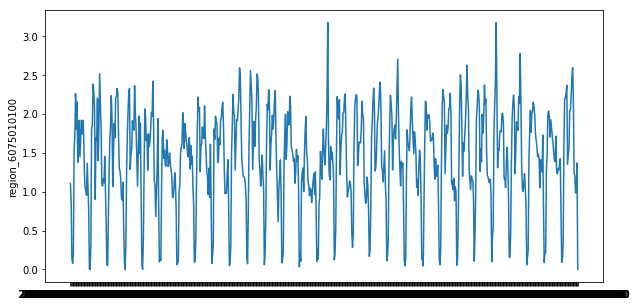

In [50]:
plt.figure(figsize=(10,5))
g = sns.lineplot(x=sample_time_series.columns, y=sample_time_series.iloc[0,:])

In [51]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range = (0,1))
# scaled_time_series = scaler.fit_transform(sample_time_series)
# # turn scaled data into df.
# sample_time_series_scale = pd.DataFrame(score_scale,index=sample_time_series.index, columns=sample_time_series.columns)
# sample_time_series_scale.head(10)

To predict the value at time $T$, based on the data from days $T-N$ where $N$ can be any number of steps. 
Lets predict the speed of the next 1 hour using the past 12 hours. 

In [52]:
# Drop the column for march
last_col = sample_time_series.columns.tolist()[-1]
sample_time_series.drop(axis=1, columns=last_col, inplace=True)

In [53]:
sample_time_series.head()

,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,2016-02-01 07:00:00,2016-02-01 08:00:00,2016-02-01 09:00:00,...,2016-02-29 14:00:00,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00,2016-02-29 21:00:00,2016-02-29 22:00:00,2016-02-29 23:00:00
region_6075010100,1.103094,0.850827,0.137040,0.078909,0.196874,1.539069,1.714272,2.258792,1.799093,2.151459,...,2.045441,2.239105,2.471772,2.591621,2.202300,1.242359,1.202609,0.981914,1.050426,1.368480
region_6075010200,4.474976,6.177880,7.323182,6.249900,5.763750,4.905341,4.557325,3.481254,1.850865,2.825775,...,2.397086,2.734535,2.477057,2.435120,3.243975,3.458722,2.948414,2.544947,2.356152,2.466459
region_6075010300,5.635000,5.944400,8.889000,1.620333,7.844551,5.532250,4.415793,4.503976,4.671350,5.090225,...,3.904699,4.047194,4.435053,4.571130,4.656116,4.763261,5.180390,5.349852,4.901961,4.934529
region_6075010400,5.674429,9.444333,6.944000,7.500000,12.778000,5.926167,4.881000,5.593897,3.988920,6.063925,...,4.967918,4.736745,4.836363,4.627703,4.603434,4.804670,4.637204,5.731026,4.656882,4.882050
region_6075010500,3.446908,6.550136,4.444000,0.000000,5.799818,5.608138,4.122118,4.304811,4.170099,4.161973,...,3.743409,4.107213,3.237954,2.903063,3.350814,3.964277,4.254140,4.476809,4.541343,4.188110


In [54]:
# Split data to train and test
split_size=0.7
train_size = round(sample_time_series.shape[1] * 0.7)
test_size = sample_time_series.shape[1] - train_size
print('Train size: {} Test size: {}'.format(train_size, test_size))

Train size: 487 Test size: 209


In [55]:
# Separate to train and test set
train_set = sample_time_series.iloc[:,0:train_size]
test_set = sample_time_series.iloc[:,train_size:]

In [56]:
# Choose row from dataset
train_set = np.array(train_set.iloc[1])
test_set = np.array(test_set.iloc[1])

Last column in the table becomes target y, and the first N colummns become our input x1, x2 and x3
Input vector for LSTM is an 3D array:
1. Num samples
2. Num time steps
3. Num features

Example: 
Imagine 50 words in one sentence, where each word is represented by a word vector. So we need 50 time steps to go through each word vector in the sentence as an input to the LSTM at each time step. There is one sentence per observation and hence num_features = 1. Like this, we need to iterate over all the sentences in the train data to extract the pattern between the words in all sentences. This is exactly what we want here in the time series forecast as well — we want to identify all the patterns that exist between each of the previous values in the window to predict the current time step!)

In [132]:
# ## code snippet: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
# split_size =0.7
# time_window = 12

# #creating dataframe
# x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
# X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])

# scaled_data = sample_time_series.iloc[1].T.to_frame()

# labels = scaled_data.index # add label

# #creating train and test sets
# dataset = scaled_data.values

# size = int(len(dataset) * split_size)

# train, test = dataset[0:size], dataset[size:len(dataset)]

# test_label =labels[size:len(labels)]# add label
# #converting dataset into x_train and y_train

# sub_x_train, sub_y_train = [], []
# for i in range(time_window,len(train)):
#     sub_x_train.append(train[i-time_window:i])
#     sub_y_train.append(train[i])
# sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
# x_train = np.concatenate((x_train, sub_x_train), axis=0)
# y_train = np.concatenate((y_train, sub_y_train), axis=0)

# # create test dataset predicting values, using past time_window from the train data
# inputs = dataset[len(dataset) - len(test) - time_window:]
# inputs = inputs.reshape(-1,1)

# sub_X_test = []
# sub_Y_test = []
# indexes = list()
# for i in range(time_window,inputs.shape[0]):
#     sub_X_test.append(inputs[i-time_window:i])
#     sub_Y_test.append(inputs[i])
# #     indexes.append(test_label[i])# add label
# sub_X_test,sub_Y_test = np.arrayA(sub_X_test), np.array(sub_Y_test)

# X_test = np.concatenate((X_test, sub_X_test), axis=0)
# Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)

In [57]:
split_size =0.7
# Use information from the past week
time_window = 24 * 7 

# Initialize LSTM input structure (3rd order tensor)
X_train, y_train = np.empty(shape=[0, time_window, 1]), np.empty(shape=[0,1])
X_test, y_test = np.empty(shape=[0, time_window, 1]), np.empty(shape=[0,1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Test with row 9 data
scaled_data = sample_time_series.iloc[8].T.to_frame()
scaled_data.head()

(0, 168, 1) (0, 1) (0, 168, 1) (0, 1)


,region_6075010900
2016-02-01 00:00:00,5.229478
2016-02-01 01:00:00,6.805500
2016-02-01 02:00:00,10.416500
2016-02-01 03:00:00,7.037545
2016-02-01 04:00:00,10.139000


In [58]:
# feature_set = []
# labels = []
# for i in range(168, 696):
#     feature_set.append(sample_time_series[i-168:i, 0])
#     labels.append(sample_time_series[i, 0])
    
# print(feature_set[0])
# print(labels[0])

In [59]:
# Add Labels
labels = scaled_data.index
print(labels[:5], '\n')
# Add values
values = scaled_data.values
print(values[:5])

Index(['2016-02-01 00:00:00', '2016-02-01 01:00:00', '2016-02-01 02:00:00',
       '2016-02-01 03:00:00', '2016-02-01 04:00:00'],
      dtype='object') 

[[ 5.22947826]
 [ 6.8055    ]
 [10.4165    ]
 [ 7.03754483]
 [10.139     ]]


In [60]:
# Split to train / test
size = int(len(values) * split_size)
train, test = values[0:size], values[size:len(values)]
print(train[:5],'\n')
print(test[:5])

[[ 5.22947826]
 [ 6.8055    ]
 [10.4165    ]
 [ 7.03754483]
 [10.139     ]] 

[[4.83440385]
 [5.173336  ]
 [4.56452903]
 [4.65316022]
 [4.15620126]]


In [67]:
# size = size of training set: 487
# labels = 696
test_labels =labels[size:len(labels)]# add label

In [ ]:

# converting dataset into x_train and y_train
sub_X_train, sub_y_train = [], []
# Time window = 168
# Generate numbers starting form 168 ... 696
for i in range(time_window,len(train)):
    sub_x_train.append(train[i-time_window:i])
    sub_y_train.append(train[i])
sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
x_train = np.concatenate((x_train, sub_x_train), axis=0)
y_train = np.concatenate((y_train, sub_y_train), axis=0)

# create test dataset predicting values, using past time_window from the train data
inputs = dataset[len(dataset) - len(test) - time_window:]
inputs = inputs.reshape(-1,1)

sub_X_test = []
sub_Y_test = []
indexes = list()
for i in range(time_window,inputs.shape[0]):
    sub_X_test.append(inputs[i-time_window:i])
    sub_Y_test.append(inputs[i])
#     indexes.append(test_label[i])# add label
sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

X_test = np.concatenate((X_test, sub_X_test), axis=0)
Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=2)

predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)

# plot
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(labels,dataset,label='Train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])

plt.plot(test_label,predict_speed, color='red',label='validation data')#
plt.legend()
plt.title('region_6075010900 LSTM prediction')

In [18]:
history.history.keys()

dict_keys(['loss'])

KeyError: 'val_loss'

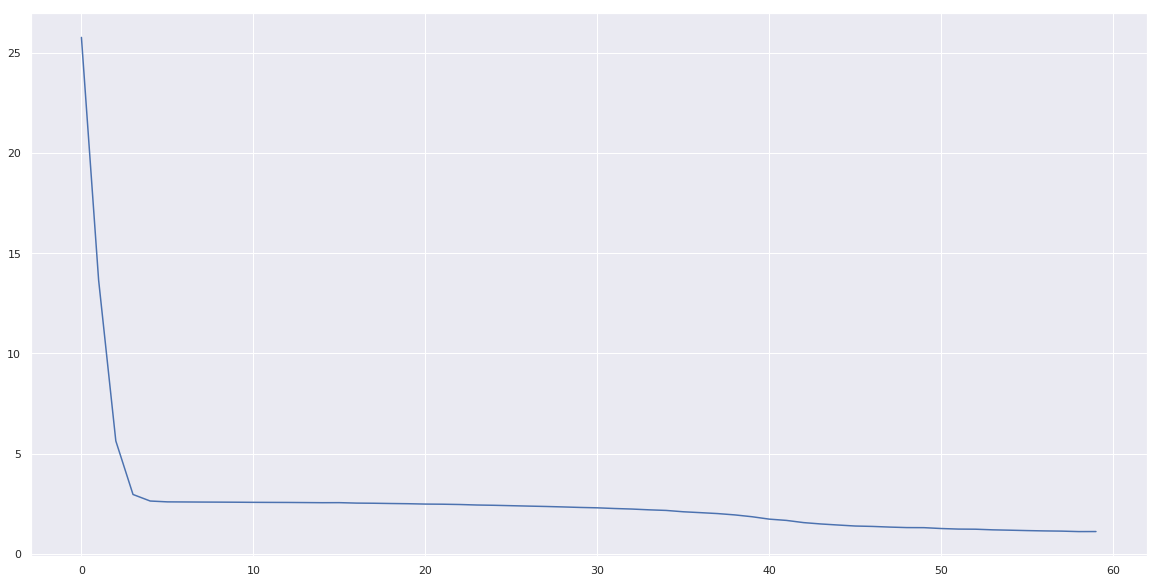

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
test_node = [x_train, y_train, X_test, Y_test]

# Get nearest-neighbors with graph

In [6]:
G = nx.read_gpickle('../../output/census.gpickle')

In [7]:
print('Graph stats:')
print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

Graph stats:
Number of nodes: 196
Number of edges: 612


In [16]:
# get node number of geoid
node = [x for x,y in G.nodes(data=True) if y['geoid'] == 6075010900]
assert len(node) == 1, 'There are more than one node with specified geoid'
 
nearest_nodes = list(G.neighbors(node[0]))
[G.node[i]['geoid'] for i in nearest_nodes]

[6075013000,
 6075011000,
 6075010800,
 6075010200,
 6075010300,
 6075013101,
 6075012902]

In [24]:
neighbor_averages = {}

for x in geoid:
    neighbor_data = sample_time_series.loc['region_' + str(x)].T.to_frame()
    
    split_size =0.7
    time_window = 12
    #creating dataframe
    x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
    X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])

    labels = neighbor_data.index # add label

    #creating train and test sets
    dataset = neighbor_data.values

    size = int(len(dataset) * split_size)

    train, test = dataset[0:size], dataset[size:len(dataset)]

    test_label =labels[size:len(labels)]# add label
    #converting dataset into x_train and y_train

    sub_x_train, sub_y_train = [], []
    for i in range(time_window,len(train)):
        sub_x_train.append(train[i-time_window:i])
        sub_y_train.append(train[i])
    sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
    x_train = np.concatenate((x_train, sub_x_train), axis=0)
    y_train = np.concatenate((y_train, sub_y_train), axis=0)

    # create test dataset predicting values, using past time_window from the train data
    inputs = dataset[len(dataset) - len(test) - time_window:]
    inputs = inputs.reshape(-1,1)

    sub_X_test = []
    sub_Y_test = []
    indexes = list()
    for i in range(time_window,inputs.shape[0]):
        sub_X_test.append(inputs[i-time_window:i])
        sub_Y_test.append(inputs[i])
    #     indexes.append(test_label[i])# add label
    sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

    X_test = np.concatenate((X_test, sub_X_test), axis=0)
    Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)
    
    neighbor_averages[str(x)] = [x_train, X_test]

In [25]:
len(neighbor_averages['6075010200'][0])

475

In [53]:
x_train_averages = []
for k,v in neighbor_averages.items():
    x_train_averages.append(neighbor_averages[str(k)][0])

x_train_averages = np.mean(x_train_averages, axis=0)

In [54]:
x_train_averages[0]

array([[4.83309838],
       [4.92469978],
       [4.87552116],
       [3.50445907],
       [4.98249093],
       [4.31890746],
       [3.98459239],
       [3.60023172],
       [3.45090929],
       [3.67386085],
       [3.63170646],
       [3.50072831]])

In [41]:
x_train_ave = np.mean((neighbor_averages['6075013000'][0], 
                       neighbor_averages['6075011000'][0], 
                       neighbor_averages['6075010800'][0],
                       neighbor_averages['6075010200'][0],
                       neighbor_averages['6075010300'][0],
                       neighbor_averages['6075013101'][0],
                       neighbor_averages['6075012902'][0]), axis=0)
print(len(x_train_ave))
x_train_ave[0]

475


array([[4.83309838],
       [4.92469978],
       [4.87552116],
       [3.50445907],
       [4.98249093],
       [4.31890746],
       [3.98459239],
       [3.60023172],
       [3.45090929],
       [3.67386085],
       [3.63170646],
       [3.50072831]])

In [55]:
x_test_averages = []
for k,v in neighbor_averages.items():
    x_test_averages.append(neighbor_averages[str(k)][1])

x_test_averages = np.mean(x_test_averages, axis=0)

In [56]:
x_test_averages[0]

array([[3.31825783],
       [3.4750376 ],
       [3.41206271],
       [3.32741034],
       [4.01889916],
       [4.34361839],
       [4.84412618],
       [5.48386348],
       [5.5429978 ],
       [5.1053857 ],
       [5.05812687],
       [4.23844404]])

In [47]:
x_test_ave = np.mean((neighbor_averages['6075013000'][1], 
                       neighbor_averages['6075011000'][1], 
                       neighbor_averages['6075010800'][1],
                       neighbor_averages['6075010200'][1],
                       neighbor_averages['6075010300'][1],
                       neighbor_averages['6075013101'][1],
                       neighbor_averages['6075012902'][1]), axis=0)
print(len(x_test_ave))
x_test_ave[0]

209


array([[3.31825783],
       [3.4750376 ],
       [3.41206271],
       [3.32741034],
       [4.01889916],
       [4.34361839],
       [4.84412618],
       [5.48386348],
       [5.5429978 ],
       [5.1053857 ],
       [5.05812687],
       [4.23844404]])

Concatenation

In [48]:
x_train_concat = np.concatenate((x_train, x_train_ave), axis=1)

In [49]:
x_train_ave[0]

array([[4.83309838],
       [4.92469978],
       [4.87552116],
       [3.50445907],
       [4.98249093],
       [4.31890746],
       [3.98459239],
       [3.60023172],
       [3.45090929],
       [3.67386085],
       [3.63170646],
       [3.50072831]])

In [51]:
x_train_concat[0]

array([[6.93677778],
       [5.03083333],
       [3.93533333],
       [6.04175   ],
       [6.82528571],
       [4.61116667],
       [5.38826136],
       [4.86753211],
       [4.34285366],
       [4.54994574],
       [4.66478161],
       [4.66913235],
       [4.83309838],
       [4.92469978],
       [4.87552116],
       [3.50445907],
       [4.98249093],
       [4.31890746],
       [3.98459239],
       [3.60023172],
       [3.45090929],
       [3.67386085],
       [3.63170646],
       [3.50072831]])

Epoch 1/60
 - 2s - loss: 22.8835
Epoch 2/60
 - 1s - loss: 4.9532
Epoch 3/60
 - 1s - loss: 2.5752
Epoch 4/60
 - 1s - loss: 2.5814
Epoch 5/60
 - 1s - loss: 2.5731
Epoch 6/60
 - 1s - loss: 2.5639
Epoch 7/60
 - 1s - loss: 2.5576
Epoch 8/60
 - 1s - loss: 2.5520
Epoch 9/60
 - 1s - loss: 2.5354
Epoch 10/60
 - 1s - loss: 2.5155
Epoch 11/60
 - 1s - loss: 2.5059
Epoch 12/60
 - 1s - loss: 2.4736
Epoch 13/60
 - 1s - loss: 2.4366
Epoch 14/60
 - 1s - loss: 2.3880
Epoch 15/60
 - 1s - loss: 2.3625
Epoch 16/60
 - 1s - loss: 2.2385
Epoch 17/60
 - 1s - loss: 2.0939
Epoch 18/60
 - 1s - loss: 1.8359
Epoch 19/60
 - 1s - loss: 1.5882
Epoch 20/60
 - 1s - loss: 1.4979
Epoch 21/60
 - 1s - loss: 1.4820
Epoch 22/60
 - 1s - loss: 1.3897
Epoch 23/60
 - 1s - loss: 1.2955
Epoch 24/60
 - 1s - loss: 1.2991
Epoch 25/60
 - 1s - loss: 1.3480
Epoch 26/60
 - 1s - loss: 1.1888
Epoch 27/60
 - 1s - loss: 1.1283
Epoch 28/60
 - 1s - loss: 1.1009
Epoch 29/60
 - 1s - loss: 1.0961
Epoch 30/60
 - 1s - loss: 1.0182
Epoch 31/60
 - 1s 

Text(0.5, 1.0, 'region_6075010100 LSTM prediction')

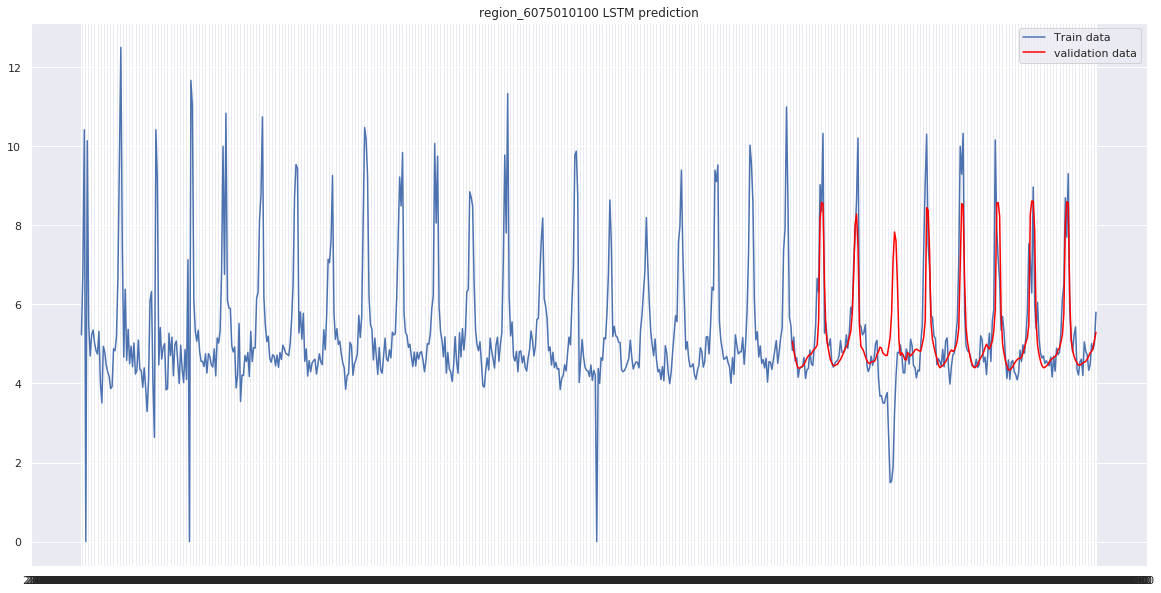

In [57]:
## code snippet: https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
split_size =0.7
time_window = 12
#creating dataframe
x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])

scaled_data = sample_time_series.iloc[8].T.to_frame()

labels = scaled_data.index # add label

#creating train and test sets
dataset = scaled_data.values

size = int(len(dataset) * split_size)

train, test = dataset[0:size], dataset[size:len(dataset)]

test_label =labels[size:len(labels)]# add label
#converting dataset into x_train and y_train

sub_x_train, sub_y_train = [], []
for i in range(time_window,len(train)):
    sub_x_train.append(train[i-time_window:i])
    sub_y_train.append(train[i])
sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
x_train = np.concatenate((x_train, sub_x_train), axis=0)
y_train = np.concatenate((y_train, sub_y_train), axis=0)

# COMBINE Averages 
x_train = np.concatenate((x_train, x_train_averages), axis=1)

# create test dataset predicting values, using past time_window from the train data
inputs = dataset[len(dataset) - len(test) - time_window:]
inputs = inputs.reshape(-1,1)

sub_X_test = []
sub_Y_test = []
indexes = list()
for i in range(time_window,inputs.shape[0]):
    sub_X_test.append(inputs[i-time_window:i])
    sub_Y_test.append(inputs[i])
#     indexes.append(test_label[i])# add label
sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

X_test = np.concatenate((X_test, sub_X_test), axis=0)
Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)

# COMBINE Averages
X_test = np.concatenate((X_test, x_test_averages), axis=1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=24, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=24))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=2)

predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)

# plot

sns.set(rc={'figure.figsize':(20,10)})

plt.plot(labels,dataset,label='Train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])

plt.plot(test_label,predict_speed, color='red',label='validation data')#
plt.legend()
plt.title('region_6075010100 LSTM prediction')

In [321]:
neighbor_averages['6075010200'][0][0]

array([[4.47497561],
       [6.17788   ],
       [7.32318182],
       [6.2499    ],
       [5.76375   ],
       [4.90534091],
       [4.557325  ],
       [3.48125373],
       [1.85086525],
       [2.8257751 ],
       [2.40547416],
       [2.52105303]])

In [323]:
neighbor_averages['6075010400'][0][0]

array([[ 5.67442857],
       [ 9.44433333],
       [ 6.944     ],
       [ 7.5       ],
       [12.778     ],
       [ 5.92616667],
       [ 4.881     ],
       [ 5.59389655],
       [ 3.98892   ],
       [ 6.06392453],
       [ 5.03227907],
       [ 4.26435135]])

In [324]:
(neighbor_averages['6075010200'][0][0] + neighbor_averages['6075010400'][0][0]) / 2

array([[5.07470209],
       [7.81110667],
       [7.13359091],
       [6.87495   ],
       [9.270875  ],
       [5.41575379],
       [4.7191625 ],
       [4.53757514],
       [2.91989262],
       [4.44484981],
       [3.71887662],
       [3.39270219]])

Access Model Training History in Keras

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 4. Make Predictions

Epoch 1/60
 - 2s - loss: 24.9484
Epoch 2/60
 - 1s - loss: 11.5793
Epoch 3/60
 - 1s - loss: 3.7375
Epoch 4/60
 - 1s - loss: 2.6491
Epoch 5/60
 - 1s - loss: 2.6071
Epoch 6/60
 - 1s - loss: 2.5855
Epoch 7/60
 - 1s - loss: 2.5756
Epoch 8/60
 - 1s - loss: 2.5511
Epoch 9/60
 - 1s - loss: 2.5249
Epoch 10/60
 - 1s - loss: 2.4942
Epoch 11/60
 - 1s - loss: 2.4628
Epoch 12/60
 - 1s - loss: 2.4208
Epoch 13/60
 - 1s - loss: 2.3828
Epoch 14/60
 - 1s - loss: 2.3421
Epoch 15/60
 - 1s - loss: 2.3055
Epoch 16/60
 - 1s - loss: 2.2329
Epoch 17/60
 - 1s - loss: 2.1737
Epoch 18/60
 - 1s - loss: 2.1272
Epoch 19/60
 - 1s - loss: 1.9896
Epoch 20/60
 - 1s - loss: 1.8420
Epoch 21/60
 - 1s - loss: 1.7305
Epoch 22/60
 - 1s - loss: 1.6464
Epoch 23/60
 - 1s - loss: 1.6245
Epoch 24/60
 - 1s - loss: 1.5623
Epoch 25/60
 - 1s - loss: 1.4819
Epoch 26/60
 - 1s - loss: 1.4266
Epoch 27/60
 - 1s - loss: 1.3763
Epoch 28/60
 - 1s - loss: 1.3350
Epoch 29/60
 - 1s - loss: 1.3317
Epoch 30/60
 - 1s - loss: 1.2845
Epoch 31/60
 - 1s

Text(0.5, 1.0, 'region_6075010900 LSTM prediction')

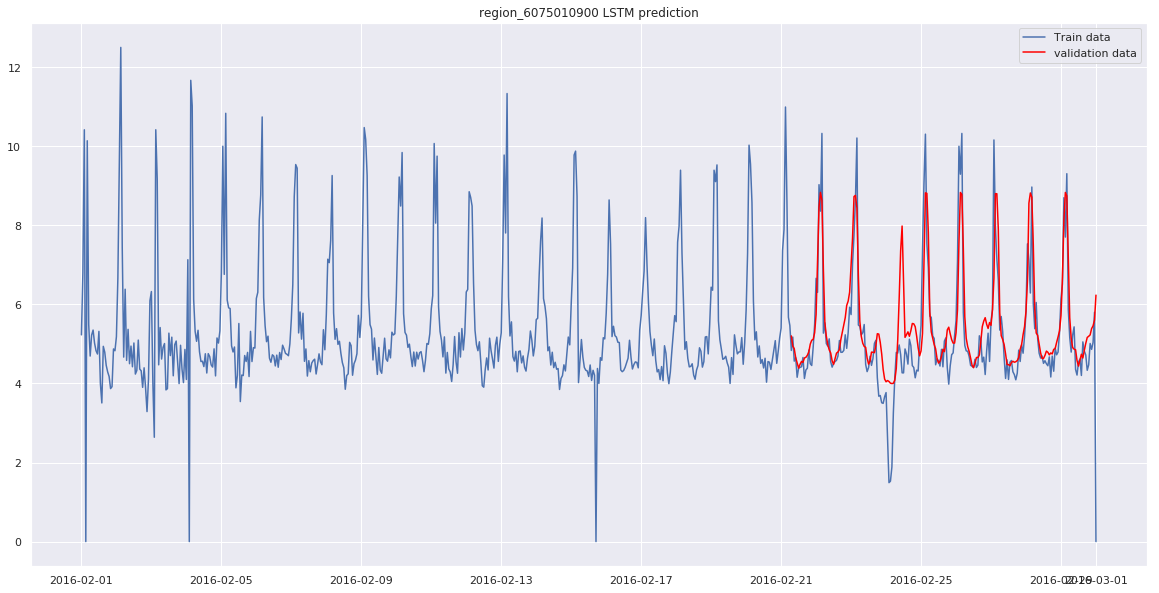

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=60, batch_size=16, verbose=2)

predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)

# plot

sns.set(rc={'figure.figsize':(20,10)})

plt.plot(labels,dataset,label='Train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])

plt.plot(test_label,predict_speed, color='red',label='validation data')#
plt.legend()
plt.title('region_6075010900 LSTM prediction')

In [70]:
from statsmodels.tsa.arima_model import ARIMA
# from code snippet: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def predict_time_series_ARIMA(mean_series,title,fig_size,split_size = 0.9,full=False):
    labels = mean_series.index # add label
    
    X = mean_series.values
    size = int(len(X) * split_size)

    train, test = X[0:size], X[size:len(X)]
    
    test_label =labels[size:len(labels)]# add label
    
    history = [x for x in train]
    predictions = list()
    indexes = list()# add label
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        indexes .append(test_label[t])# add label
#         if t %100 ==0:
#             print('predicted=%f, expected=%f' % (yhat, obs))
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    print('Test RMSE: %.3f' % np.sqrt(mse))
    print('Test MAE: %.3f' % mae)
    
    # plot
    
    sns.set(rc={'figure.figsize':fig_size})
    if full:
        plt.plot(labels,X,label = 'train data')
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])
    else:
        plt.plot(indexes,test)
    plt.plot(indexes,predictions, color='red',label='validation data')#
    plt.legend()
    plt.title(title)
    
    return plt, mse

Test RMSE: 1.091
Test MAE: 0.692


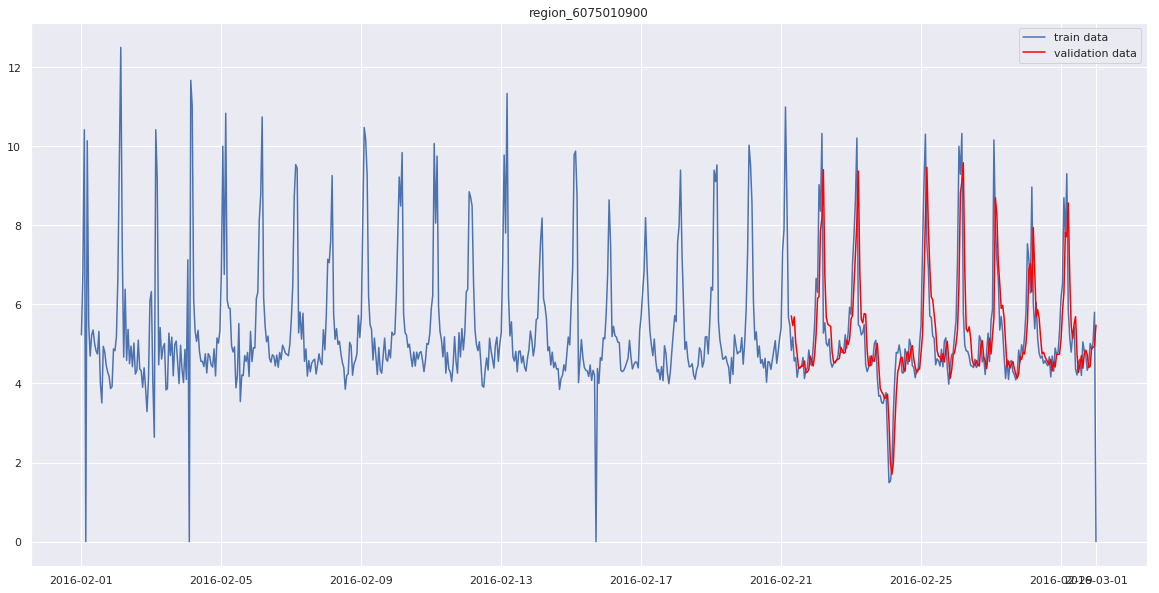

In [71]:
plt, mse = predict_time_series_ARIMA(sample_time_series.iloc[8],title = sample_time_series_scale.index[8],fig_size = (20,10),split_size = 0.7,full = True)

The input of LSTM is a list of states (timestamps) 
- For each timestamp, state is initialized as a **feature vector**
- Previously, we were extracting features (feature vector) from a **single** time series 
- New approach is to extract the same set of features (feature vector) from **multiple time series** and concatenate them into one vector 

Example: 
```python
feature_set = []
labels = []
for i in range(60, 1260):
    feature_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])
```

The code above creates a list of 60-dimensional vectors from 1 time series
Suppose we wanted to look at 2 regions (2 different time series) at a time. We would simply need to create a list of 120-dimensional vectors (60 dimensions from 1 time series) 

Each region is a time series  
> x.shape -> (regions, time_window, features)  
> y.shape -> (regions, features) 

Currently, features is 1 (just speed, no other metric)

1. https://stackoverflow.com/questions/45012992/how-to-prepare-data-for-lstm-when-using-multiple-time-series-of-different-length
2. https://machinelearningmastery.com/lstm-model-architecture-for-rare-event-time-series-forecasting/

In [84]:
# np.atleast_2d([[[1,0], [1,2]],
#                [[2,0], [1,1]]])

# 2x2 matrix
a = np.array([[0, 1],[2, 3]])
print(a.shape)

b = np.expand_dims(a, axis=1)
print(b.shape)

(2, 2)
(2, 1, 2)


In [89]:
sample_time_series.shape

(196, 697)

In [ ]:
input_list = [np.expand_dims(np.atleast_2d(data[i:examples+i,:]), axis=0) for i in xrange(nb_samples)]
input_mat = np.concatenate(input_list, axis=0)

In [110]:
np.expand_dims(np.atleast_2d(sample_time_series.iloc[:,0:6]), axis=0).shape

(1, 196, 6)

In [62]:
# # Multi-Time Series Testing
# # https://gist.github.com/lukovkin/1aefa4509e066690b892
# import keras.callbacks
# from keras.models import Sequential  
# from keras.layers.core import Dense, Activation, Dense, Dropout
# from keras.layers.recurrent import LSTM

# # Call back to capture losses 
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))

# Load data values 
data = sample_time_series.values

# Specify range of sliding window 
examples = 24 # past 24 x 
y_examples = 1 # Predict next y value 

nb_samples = len(data) - examples - y_examples 

# np.atleast_2d - read input if array is at least 2 dimensions. If not 2d, make it into 2d. 
# np.expand_dims - expand the shape of an array. Insert new axis that will appear at the axis position 
# in the expanded array shape. 

input_list = [np.expand_dims(np.atleast_2d(data[i:examples+i,:]), axis=0) for i in xrange(nb_samples)]
input_mat = np.concatenate(input_list, axis=0)

# target - the first column in merged dataframe
target_list = [np.atleast_2d(data[i+examples:examples+i+y_examples,0]) for i in xrange(nb_samples)]
target_mat = np.concatenate(target_list, axis=0)

# set up model
trials = input_mat.shape[0]
features = input_mat.shape[2]
hidden = 64
model = Sequential()
model.add(LSTM(hidden, input_shape=(examples, features)))
model.add(Dropout(.2))
model.add(Dense(y_examples))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

# Train
history = LossHistory()
model.fit(input_mat, target_mat, nb_epoch=100, batch_size=400, callbacks=[history])

array([[1.10309386, 0.85082677, 0.13704   , ..., 1.05042637, 1.36847996,
        0.        ],
       [4.47497561, 6.17788   , 7.32318182, ..., 2.35615152, 2.46645894,
        0.        ],
       [5.635     , 5.9444    , 8.889     , ..., 4.90196078, 4.93452941,
        0.        ],
       ...,
       [3.6389    , 8.611     , 0.        , ..., 5.31354839, 2.24141379,
        0.        ],
       [0.70871708, 0.54082318, 0.11789213, ..., 1.08395936, 1.190752  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
feature_set = []
labels = []

for i in range(72, 697):
    multi_region_data = []
    for j in sample_time_series_scale.itertuples():
        one_region_data = np.array(list(j)[1:])
        one_region_data[i-72:i]
        multi_region_data += one_region_data
        print(row_data[i])
#        feature_set.append(row_data[i-72:i])
#        labels.append(row_data[i])
        break
#     feature_set.append(sample_time_series_scale[i-72:i, 0])
#     labels.append(sample_time_series_scale[i, 0])
    break

[0.06462957 0.0470709  0.00930841 0.00373782 0.00845006 0.08237146
 0.08452446 0.16475164 0.13924162 0.14358263 0.10654545 0.1001483
 0.14583433 0.101467   0.09550655 0.12943227 0.1113016  0.13454274
 0.10317586 0.06515809 0.06496353 0.0677472  0.06731226 0.07636183
 0.05516506 0.03936906 0.         0.         0.01653122 0.09480051
 0.09408792 0.17438377 0.17960234 0.1482391  0.07099821 0.11999029
 0.10193609 0.14654252 0.09085923 0.13135883 0.19096929 0.18325578
 0.11824407 0.06348661 0.0703877  0.08088135 0.07958582 0.10045093
 0.06067606 0.0284386  0.00316188 0.00351249 0.02886563 0.06000166
 0.0868982  0.13891425 0.1748322  0.1203726  0.07781057 0.11962411
 0.10746173 0.11526035 0.14353807 0.14678893 0.15524548 0.18075691
 0.10268999 0.06819208 0.07455115 0.06616545 0.06527697 0.05211446]
0.062428586468653215


In [ ]:
features_set = []  
labels = []  
for i in range(72, 697):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])

In [ ]:
split_size = 0.7
time_window = 3
#creating dataframe
x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])

scaled_data = sample_time_series.iloc[8].T.to_frame()


features_set = []  
labels = []  
for i in range(60, 1260):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])


split_size =0.7
time_window = 72
#creating dataframe
x_train, y_train = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
X_test, Y_test = np.empty(shape=[0, time_window, 1]),np.empty(shape=[0,1])
for i, row in sample_time_series_scale.iterrows():
    scaled_data = row.T.to_frame()

    labels = scaled_data.index # add label

    #creating train and test sets
    dataset = scaled_data.values

    size = int(len(dataset) * split_size)

    train, test = dataset[0:size], dataset[size:len(X)]

    test_label =labels[size:len(labels)]# add label
    #converting dataset into x_train and y_train

    sub_x_train, sub_y_train = [], []
    for i in range(time_window,len(train)):
        sub_x_train.append(train[i-time_window:i])
        sub_y_train.append(train[i])
    sub_x_train, sub_y_train = np.array(sub_x_train), np.array(sub_y_train)
    x_train = np.concatenate((x_train, sub_x_train), axis=0)
    y_train = np.concatenate((y_train, sub_y_train), axis=0)

    # create test dataset predicting values, using past time_window from the train data
    inputs = dataset[len(dataset) - len(test) - time_window:]
    inputs = inputs.reshape(-1,1)

    sub_X_test = []
    sub_Y_test = []
    indexes = list()
    for i in range(time_window,inputs.shape[0]):
        sub_X_test.append(inputs[i-time_window:i])
        sub_Y_test.append(inputs[i])
    #     indexes.append(test_label[i])# add label
    sub_X_test,sub_Y_test = np.array(sub_X_test), np.array(sub_Y_test)

    X_test = np.concatenate((X_test, sub_X_test), axis=0)
    Y_test = np.concatenate((Y_test, sub_Y_test), axis=0)





# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=16, verbose=2)


predict_speed = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test, predict_speed)
lstm_mae = mean_absolute_error(Y_test, predict_speed)
print('Test RMSE: %.3f' % np.sqrt(lstm_mse))
print('Test MAE: %.3f' % lstm_mae)



https://stackoverflow.com/questions/42585356/how-to-construct-input-data-to-lstm-for-time-series-multi-step-horizon-with-exte/42599514#comment81441573_42599514

Input data structure example:  
(300, 20 1) - translates to - 300 time series of length 20 with 1 feature  
sequential_input = Input(shape=(20,1)) - shape is length of 20 and 1 feature

In this case your input should consist of list of two tables: [sequential_data, features] where sequential_data.shape = (nb_of_examples, timesteps, sequential_features) and features.shape = (nb_of_examples, feature_nb). So sales or temperature should be stored in sequential_features and store_type in features.
output = Dense(10)(blend)
model = Model(input=[sequential_input, feature_input], output=output])

## Scaling up the model to multiple time-series
- training separate neural network for every city is inefficient
- train single neural network on all city data

In [ ]:

- Manually encoding city level features is prone to error
- Use LSTM to automate feature extraction 

# Data Normalization
- MinMaxScaler from sklearn.preprocessing to scale data from 0 and 1. 
- feature_range parameter specifies the range of scaled data

# Predict value at time T, based on data from days T-N 

In [ ]:
features_set = []  
labels = []  
for i in range(60, 1260):  
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)  

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Instantiate model class `Sequential` 
- Add LSTM, Dropout, and Dense layers to this model

In [ ]:
model = Sequential()

- `add` method adds layers to sequential model
- first parameter to the LSTM layer is the number of neurons
- second parameter is `return_sequences` which is set to true since we will add more layers
- `input_shape` is the number of timesteps
- last paramter is the number of indicators
- `Dropout` layer is added to avoid over-fitting (when models perform better on training data compared to test data) 
- `Dense` layer makes the model more robust. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output 
- Compile LSTM model, specifiying the lsos function and optimizer 
- fit the model with the feature set. Specifying epochs, and batchsize. 


## 8. Impute nan values using weighted ave of nearest neighbors

In [1]:
G = nx.read_gpickle('../../output/census_filtered.gpickle')
print('Graph stats:')
print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

NameError: name 'nx' is not defined

In [ ]:
neighbors = n_nearest_neighbors(G, 6075990100)
neighbors = ["region_" + str(x) for x in neighbors]
neighbors

In [ ]:
# Get time series of neighboring regions 
time_series[time_series.index.isin(neighbors)]